# Higgs Boson Machine Learning Classification

## First let's have all the useful libraries:

In [32]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

## Now let's have a look to the dataset

In [33]:
data_full = pd.read_csv('dataset_higgs_challenge.csv')
data_full.head(10)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
5,100005,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,...,-2.412,-0.653,56.165,0.224,3.106,193.660,0.025434,b,t,0.083414
6,100006,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,...,0.864,1.450,56.867,0.131,-2.767,179.877,0.000814,s,t,0.002653
7,100007,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,...,-0.715,-1.724,-999.000,-999.000,-999.000,30.638,0.005721,s,t,0.018636
8,100008,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,4.288,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.614803,b,t,5.296003
9,100009,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,28.859,...,-2.767,-2.514,-999.000,-999.000,-999.000,167.735,0.000461,s,t,0.001502


In [34]:
print('Total number of events: ', len(data_full), '\n')
for KaggleSetID in ['t', 'b', 'v', 'u']:
    print('Number of events in the {} KaggleSet: {}'
          .format(KaggleSetID, len(data_full['KaggleSet'][data_full['KaggleSet']==KaggleSetID])))

Total number of events:  818238 

Number of events in the t KaggleSet: 250000
Number of events in the b KaggleSet: 100000
Number of events in the v KaggleSet: 450000
Number of events in the u KaggleSet: 18238


## Now let's split the data into training and validation set

In [35]:
train_data = data_full[data_full['KaggleSet']=='t']
validation_data = data_full[data_full['KaggleSet']=='b']

y_train = pd.get_dummies(train_data['Label']).values.astype(float) #signal = [0,1], background = [1,0]
y_val = pd.get_dummies(validation_data['Label']).values.astype(float)

len(train_data), len(validation_data)

(250000, 100000)

## Ok first let's try to perform cuts on unuseful variables

First I cut off all the data that have:

1) Meaningless values (-999) on the jets.

2) Number of jets < 2.

And of course i put all the VBF cuts (for now i classify just using VBF data).

In [36]:
X = train_data.iloc[:,1:-4]
X_val = validation_data.iloc[:,1:-4]

X_2jets = X[ X['PRI_jet_num']==0 ].drop(['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 
                                         'DER_lep_eta_centrality', 'PRI_jet_num', 'PRI_jet_leading_pt', 
                                         'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 
                                         'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'], 
                                        axis =1)

X_2jets = X[ X['PRI_jet_num']>=2 ]
X_val_2jets = X_val[ X_val['PRI_jet_num']>=2 ]
X_VBF = X_2jets [ (X_2jets['PRI_jet_leading_pt'] >= 50) & (X_2jets['PRI_jet_subleading_pt'] >= 30) & 
                 (X_2jets['DER_deltaeta_jet_jet'] >= 3) & (X_2jets['DER_mass_vis']>=40) ]
X_val_VBF = X_val_2jets [ (X_val_2jets['PRI_jet_leading_pt'] >= 50) & (X_val_2jets['PRI_jet_subleading_pt'] >= 30)
                         & (X_val_2jets['DER_deltaeta_jet_jet'] >= 3) & (X_val_2jets['DER_mass_vis']>=40) ]


y_train_2jets = y_train[ X['PRI_jet_num']>=2 ]
y_val_2jets = y_val[ X_val['PRI_jet_num']>=2 ]
y_train_VBF = y_train_2jets [ (X_2jets['PRI_jet_leading_pt'] >= 50) & (X_2jets['PRI_jet_subleading_pt'] >= 30) &
                             (X_2jets['DER_deltaeta_jet_jet'] >= 3) & (X_2jets['DER_mass_vis']>=40) ]
y_val_VBF = y_val_2jets [ (X_val_2jets['PRI_jet_leading_pt'] >= 50) & (X_val_2jets['PRI_jet_subleading_pt'] >= 30) 
                         & (X_val_2jets['DER_deltaeta_jet_jet'] >= 3) & (X_val_2jets['DER_mass_vis']>=40) ]

In [37]:
len (X_VBF)

21257

In [38]:
len (X_val_VBF)

8489

In [39]:
len(y_train_VBF)

21257

In [40]:
len(y_val_VBF)

8489

## Let's perform a scaling of input variables


In [42]:
from sklearn.preprocessing import StandardScaler #This is the best one (I tried also other of course)
minmax_VBF = StandardScaler()
minmax_VBF.fit(X_VBF)
X_VBF_minmax = minmax_VBF.transform(X_VBF)
X_val_VBF_minmax = minmax_VBF.transform(X_val_VBF)

#validation set needs to be scaled right?

## Now let's use a DNN

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from keras.regularizers import l1
from keras.layers import Dropout
#Too much higher validation loss in data. So i added a regularizer.
#I added also dropout to have better shape. 

model_1 = Sequential()
l1_lambda = 0.0001
dropout=0.2
model_1.add(Dense(units=128, activation='relu', kernel_regularizer=l1(l1_lambda), input_dim=30))
model_1.add(Dropout(dropout))
model_1.add(Dense(units=64, activation='relu', kernel_regularizer=l1(l1_lambda)))
model_1.add(Dropout(dropout))
model_1.add(Dense(units=32, activation='relu', kernel_regularizer=l1(l1_lambda)))
model_1.add(Dropout(dropout))
model_1.add(Dense(units=16, activation='relu', kernel_regularizer=l1(l1_lambda)))
model_1.add(Dropout(dropout))
model_1.add(Dense(units=8, activation='relu', kernel_regularizer=l1(l1_lambda)))
model_1.add(Dropout(dropout))
model_1.add(Dense(units=4, activation='relu', kernel_regularizer=l1(l1_lambda)))
model_1.add(Dropout(dropout))
model_1.add(Dense(units=2, activation='softmax'))

model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               3968      
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_33 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 16)               

In [44]:
model_1.compile(optimizer='adagrad', #adagrad is the best one for this classification.
              loss='categorical_crossentropy', #This seems one of the best loss function.
              metrics=['accuracy'])

In [45]:
#I added the part of the validation set.

history = model_1.fit(X_VBF_minmax, y_train_VBF, batch_size=512, epochs=130, verbose=1, 
                  validation_data=(X_val_VBF_minmax, y_val_VBF))

Train on 21257 samples, validate on 8489 samples
Epoch 1/130
21257/21257 [==============================] - 1s 25us/step - loss: 0.6739 - accuracy: 0.7341 - val_loss: 0.5423 - val_accuracy: 0.8278
Epoch 2/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.5765 - accuracy: 0.7993 - val_loss: 0.4805 - val_accuracy: 0.8497
Epoch 3/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.5283 - accuracy: 0.8240 - val_loss: 0.4557 - val_accuracy: 0.8588
Epoch 4/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.5079 - accuracy: 0.8345 - val_loss: 0.4418 - val_accuracy: 0.8618
Epoch 5/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.4935 - accuracy: 0.8396 - val_loss: 0.4345 - val_accuracy: 0.8637
Epoch 6/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.4849 - accuracy: 0.8430 - val_loss: 0.4266 - val_accuracy: 0.8652
Epoch 7/130
21257/21257 [==============================] - 0s 1

Epoch 56/130
21257/21257 [==============================] - 0s 12us/step - loss: 0.3849 - accuracy: 0.8731 - val_loss: 0.3601 - val_accuracy: 0.8764
Epoch 57/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3858 - accuracy: 0.8706 - val_loss: 0.3599 - val_accuracy: 0.8776
Epoch 58/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3807 - accuracy: 0.8753 - val_loss: 0.3591 - val_accuracy: 0.8782
Epoch 59/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3814 - accuracy: 0.8761 - val_loss: 0.3580 - val_accuracy: 0.8767
Epoch 60/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3816 - accuracy: 0.8735 - val_loss: 0.3571 - val_accuracy: 0.8769
Epoch 61/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3796 - accuracy: 0.8753 - val_loss: 0.3595 - val_accuracy: 0.8775
Epoch 62/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3764 - accuracy: 0.8742

Epoch 111/130
21257/21257 [==============================] - 0s 14us/step - loss: 0.3618 - accuracy: 0.8777 - val_loss: 0.3474 - val_accuracy: 0.8781
Epoch 112/130
21257/21257 [==============================] - 0s 14us/step - loss: 0.3601 - accuracy: 0.8780 - val_loss: 0.3478 - val_accuracy: 0.8764
Epoch 113/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3558 - accuracy: 0.8823 - val_loss: 0.3485 - val_accuracy: 0.8773
Epoch 114/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3559 - accuracy: 0.8819 - val_loss: 0.3478 - val_accuracy: 0.8780
Epoch 115/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3594 - accuracy: 0.8807 - val_loss: 0.3460 - val_accuracy: 0.8780
Epoch 116/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3582 - accuracy: 0.8799 - val_loss: 0.3472 - val_accuracy: 0.8781
Epoch 117/130
21257/21257 [==============================] - 0s 13us/step - loss: 0.3560 - accuracy:

I can now plot the loss evolution over the training epochs for the training and validation dataset:

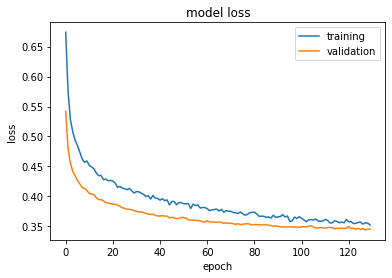

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

I can plot also the accuracy:

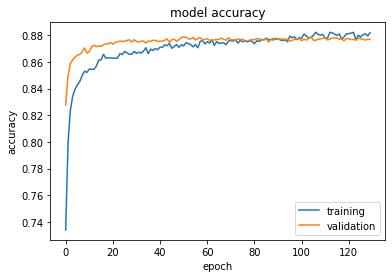

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

## Let's see how has gone the classification

In [48]:
y_pred = model_1.predict(X_val_VBF_minmax)
y_pred

array([[5.9009243e-02, 9.4099075e-01],
       [5.9818476e-01, 4.0181527e-01],
       [1.7099355e-04, 9.9982893e-01],
       ...,
       [5.6183253e-05, 9.9994385e-01],
       [3.3732694e-01, 6.6267300e-01],
       [4.9982700e-02, 9.5001727e-01]], dtype=float32)

(array([ 445.,    0., 7444.,    0.,  600.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ]),
 <a list of 5 Patch objects>)

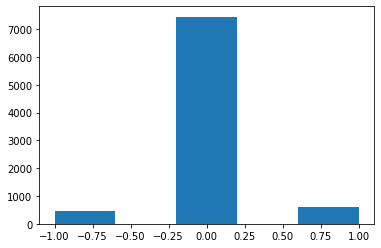

In [49]:
plt.hist(np.argmax(y_pred, axis=1)-np.argmax(y_val_VBF, axis=1), bins=5)

## Evaluation of the model with different tools

In [53]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Explained variance score: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_val_VBF, y_pred))
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_val_VBF, y_pred))
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_val_VBF, y_pred))

Coefficient of determination: 0.58
Mean squared error: 0.09
Mean absolute error: 0.17
